# Simulate gamma ray sources in galaxy

In [1]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
import healpy as hp
import makemap
from matplotlib import gridspec

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
#constants 
kpc = 3.08567758e21 #cm

##From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.083 #jian-wen xu et al 2004
Rsun = 8.3
hb = 10 #This is considered as high latitude
##This is for pulsars
model = 'C' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4

#Trheshold of fermi, from 3fgl paper
fermi_thres = 5e-10

##Setting up some things for later
minflux,maxflux=-14,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.

lb = [(180,20),(180,5),(180,1),(20,20),(20,5),(20,1)]

##Set up bins for energy for fhl (10-1000GeV) and fgl (0.1-100GeV)
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
#bins in energy for our use (1-1000GeV)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E3fhl = E>100
mask_E = (E>=1)&(E<=100)

Lmin_tev = 3.96e34
Lmax_tev = 1.79e38

In [22]:
#Function definitions

def R_dep(R,alpha=alp, beta=bet):
    "R distribution of sources from lorimer"
    "Deprecrated?"
    return ((R/Rsun)**alpha)*np.exp(-beta*(R-Rsun)/Rsun)

##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def rand_L(u,a,Lmin,Lmax):
    if a==1:
        print "a==1, error"
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))

def convertlb_px(l,b):
    "deprecrated?"
    lpix = 2*l+360
    bpix = -2*b+40
    return int(lpix),int(bpix)

def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm

def read_catalog(fn,catalog='fgl',classes=['pwn','snr','spp']):
    data = fits.getdata(fn)
    tb = Table(data)
    if catalog=='fgl':
        cls = np.asarray(tb['CLASS1'].tolist())
    else:
        cls = np.asarray(tb['CLASS'].tolist())
    cls = np.char.lower(np.char.rstrip(cls,' '))
    mask = np.zeros_like(cls,dtype=bool)
    for m in classes:
        mask = (cls==m)|mask
    if catalog == 'fgl':
        flux = tb[mask]['Flux1000']
    spec = catalog_spect.get_spec(fn)
    hist_3fgl = np.histogram(flux,bins=bins)[0]
    total_flux = np.sum(flux)
    #max_spec = np.amax(spec,axis=1)
    #spec = spec_3fgl/max_spec[:,None] #Normalize to get average spectrum not depended on total flux
    spec = spec[mask]
    #for sp in spec:
    #    plt.loglog(E3fgl,E3fgl**2*sp,color='gray')
    ind = np.mean(tb[mask]['Spectral_Index'])
    plotfunc = lambda E,a,b: b*(E)**-a
    spec = plotfunc(E,ind,1e-10)
    
    
    good_spec = norm_spec(spec,total_flux,dE,mask_E)
    #print flux
    #print np.sum(good_spec[mask_E]*dE[mask_E])
    spec_normed = good_spec/np.max(good_spec)
    #plt.loglog(E,E**2*spec_normed)
    return hist_3fgl,spec_normed,ind

In [23]:
##Load 3fgl data and get average spectrum and histogram of fluxes from here
file_3fgl = 'gll_psc_v16.fit'
data_3fgl = fits.getdata(file_3fgl)
hist_3fgl_snr,intp_3fgl_snr_normed,snr_index = read_catalog('gll_psc_v16.fit')

In [24]:
###Load diffuse flux from skyfact fit

import open_dat

def read_datfile(datFile):
    "Read dat file and return total gas spec"
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
    return total_gas_spec/deltaE,E_diff,total_gas_err/deltaE
    

dict_files = {}
spec_diff_lb = []
diff_index_lb = []
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)
for ilb in lb:
    datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
    spec,E_diff,error = read_datfile(datfile)
    mask_E_diff = E_diff > 2
    E_diff = E_diff[mask_E_diff]
    spec = spec[mask_E_diff]
    
    fit,cov = curve_fit(fitfunc,np.log10(E_diff),
                        np.log10(spec),sigma=error[mask_E_diff]/spec)
    
    ####
    ####This matters a lot!
    diff_index = fit[0]
    #print diff_index
   # plt.loglog(E_diff,E_diff**2*plotfunc(E_diff,fit[0],10**fit[1]))
   # plt.loglog(E_diff,E_diff**2*spec,
   #                       marker='.',linestyle='',label=ilb)
    fitted_spec = plotfunc(E,diff_index,10**fit[1]) ##If this is a softer spectra this matters a lot!
    spec_diff_lb.append(fitted_spec)
   # print fit[0]
       # plt.loglog(E,E**2*fitted_spec)
        #plt.legend()
        

In [25]:
#Do the simulation monte carlo
def mc_smpl(a=2,N=1000,Lmin=3e34,Lmax=1e40,alpha=alp,beta=bet,H=H,
            SNR=False,PSR=False,f_t=5e-10,flux_cutoff=1e-20):
    #np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth.
    Returns histogram of sources, total flux from sources and average spec from sources and
    fraction of unresolved/diffuse.
    """
    
    N = int(N) #no samples just to be sure 
    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    z_smpl = rand_z(N,H)
    R_smpl = rand_R(N,alpha,beta)
    
    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)

    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi
        
    #histogram for normalization
    hist = np.histogram(flux_data,bins=bins)[0]
    
    #Fluxes at different regions
    dict_flux_lb = {}
    dict_flux_lb['lb']=[]
    dict_flux_lb['flux100']=[]
    spec_unres = []
    frac = []
    for ilb,_lb in enumerate(lb):
        ll,bb = _lb
        mask_l = np.abs(l)<=ll
        mask_b = np.abs(b)<=bb
        total_flux_lb = flux_data[mask_l&mask_b]
        flux_unresolved = total_flux_lb[total_flux_lb<f_t]
        flux_unresolved[flux_unresolved<flux_cutoff]=0
        total_flux_unres = np.sum(flux_unresolved)
        dict_flux_lb['lb'].append((ll,bb))
        dict_flux_lb['flux100'].append(total_flux_unres)
        if SNR:
            spec_sim = norm_spec(intp_3fgl_snr_normed,total_flux_unres,dE,mask_E)
        elif PSR:
            spec_sim = norm_spec(intp_3fgl_psr_normed,total_flux_unres,dE,mask_E)
        else:
            print "no spec output"
            spec_sim = 0
        diffuse = spec_diff_lb[ilb]
        frac.append(spec_sim/diffuse)
        spec_unres.append(spec_sim)

    return hist,dict_flux_lb,frac,spec_unres

In [26]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources

def ave_samples(Nsmpl=10,Nsnr=100000,Npsr=20000,LF_i_snr=1.5,LF_i_psr=1.7,
                Lmin_snr=1e33,Lmax_snr=4e38,Lmin_psr=1e34,Lmax_psr=1e40,
                ft=5e-9,flux_cutoff = 1e-20,plothist=False,printstatements=False):

    print "Doing %s sample galaxys with %s SNR's and %s PSR's,SNR_LF_i = %s, this might take some time..."%(Nsmpl,Nsnr,Npsr,LF_i_snr)
    fluxes_snr = []
    fluxes_psr = []
    hist_snr = np.zeros((Nsmpl,len(bins_mean)))
    hist_psr = np.zeros((Nsmpl,len(bins_mean)))
    frac_snr = []
    frac_psr = []
    spec_snr = []
    for i in range(Nsmpl):
        if i%(Nsmpl/10.)==0 and printstatements:
            print 100*i/float(Nsmpl),"% done"
        hist_snr[i,:],dict_snr,ifrac_snr,ispec_snr = mc_smpl(LF_i_snr,Nsnr,Lmin_snr,Lmax_snr,
                                                             alp_snr,bet_snr,H_snr,SNR=True,f_t=ft,
                                                             flux_cutoff=flux_cutoff)
        #hist_psr[i,:],dict_psr,ifrac_psr = mc_smpl(LF_i_psr,Npsr,Lmin_psr,Lmax_psr,alp,bet,PSR=True,f_t=ft,flux_cutoff=flux_cutoff)
        fluxes_snr.append(dict_snr['flux100'])
        #fluxes_psr.append(dict_psr['flux100'])
        frac_snr.append(ifrac_snr)
        #frac_psr.append(ifrac_psr)
        spec_snr.append(ispec_snr)

    ave_frac_snr = np.average(frac_snr,axis=0) #For a roi a fraction for every E bin
    #ave_frac_psr = np.average(frac_psr,axis=0)
    
    ave_flux_snr = np.average(fluxes_snr,axis=0)
    #ave_flux_psr = np.average(fluxes_psr,axis=0)
    ave_hist_snr = np.rint(np.mean(hist_snr,axis=0))
    #ave_hist_psr = np.rint(np.mean(hist_psr,axis=0))
    ave_spec_snr = np.average(spec_snr,axis=0)
    
    mask_complete = (bins_mean > 5e-9)
    counts_snr = np.sum(ave_hist_snr[mask_complete])
    counts_3fgl_snr = np.sum(hist_3fgl_snr[mask_complete])

    if plothist:
        #print counts_snr, counts_3fgl_snr
        ###################
        #Histogram of flux vs N

        f1,ax1 = plt.subplots(1,figsize=(12,8))
        ax1.loglog(bins_mean,ave_hist_snr,marker='^',label='sim snr', color='green')
       # ax1.loglog(bins_mean,ave_hist_psr,marker='v',label='sim psr', color='peru')
        ax1.loglog(bins_mean,hist_3fgl_snr,marker='^', color='orange', label='3fgl SNR')
        #ax1.loglog(bins_mean,hist_3fgl_psr,marker='v', color='purple', label='3fgl PSR') 
        ax1.set_title([Nsnr,LF_i_snr,Lmin_snr])
        ax1.set_xlabel(r'flux ph $cm^{-2} s^{-1}$')
        ax1.set_ylabel('Source counts')
        ax1.legend(prop={'size':20})
        
    return ave_frac_snr,ave_spec_snr#,ave_frac_psr,LL



In [27]:
## Fix Nsnr and index LF snr
ind = 1.7
Nn = 30000

options_labels = ['Nsnr','LF_i_snr','Lmin_snr','Lmax_snr','flux_cutoff','fermi_thres']
lmax = 5e38

options = [(10000,1.5,5e32,lmax),(10000,1.6,3e33,lmax),(150000,1.8,5e32,lmax),(100000,1.9,3e33,lmax),
           (10000,1.8,1.7e34,lmax),(30000,1.9,1.7e34,lmax),(60000,2.1,1.7e34,lmax),(6000,1.5,2e33,5e38),
          (15000,1.6,2e33,5e38),(30000,1.7,2e33,5e38),(70000,1.8,2e33,5e38),
           (160000,1.9,2e33,5e38),(300000,2.0,2e33,5e38),(600000,2.1,2e33,5e38)]

options = [(6000,1.5,3e33,5e38),(15000,1.6,3e33,5e38),(30000,1.7,3e33,5e38),(70000,1.8,3e33,5e38),
           (160000,1.9,3e33,5e38),(300000,2.0,3e33,5e38),(600000,2.1,2e33,5e38),(150000,2.0,6e33,5e38)] 

options = [(6000,1.5,3e33,5e38),(15000,1.6,3e33,5e38),(30000,1.7,3e33,5e38),(70000,1.8,3e33,5e38),
           (160000,1.9,3e33,5e38),(150000,2.0,6e33,5e38),(200000,1.6,1e32,1e38),(200000,2.1,1e34,1e38)]

options = []
Lmin = np.logspace(32,35,20)
Ind = np.arange(1.5,2.2,0.1)
Nn = 50000

for lmin in Lmin:
    for ind in Ind:
        options.append((Nn,ind,lmin,lmax))

options = [(Nn,1.5,1e32,5e38),(Nn,1.6,7e32,5e38),(Nn,1.7,2e33,lmax),(Nn,1.8,6e33,lmax),(Nn,1.9,1e34,lmax),
           (Nn,2.0,2e34,lmax),(Nn,2.1,3.5e34,lmax)]

Lmin = 2e34
Lmax = 2e38
options = [(50000,2.1,3e34,Lmax),(140000,2.1,1e34,Lmax),(2500,1.5,3e34,Lmax),(5000,1.5,1e34,Lmax)]

snr_frac = []
options_print = []
snr_spec = []
for op in options:
    N,LF_i,Lmin,Lmax = op
    ave_frac_snr,ave_spec_snr = ave_samples(10,Nsnr=N,Npsr=0,LF_i_snr=LF_i,Lmin_snr=Lmin,Lmax_snr=Lmax)
                                           #,plothist=True,printstatements=False)
    options_print.append(op)
    #print Lmin,Lmax
    snr_frac.append(ave_frac_snr)
    snr_spec.append(ave_spec_snr)
#print snr_frac
print "done..."

Doing 10 sample galaxys with 50000 SNR's and 0 PSR's,SNR_LF_i = 2.1, this might take some time...
Doing 10 sample galaxys with 140000 SNR's and 0 PSR's,SNR_LF_i = 2.1, this might take some time...
Doing 10 sample galaxys with 2500 SNR's and 0 PSR's,SNR_LF_i = 1.5, this might take some time...
Doing 10 sample galaxys with 5000 SNR's and 0 PSR's,SNR_LF_i = 1.5, this might take some time...
done...


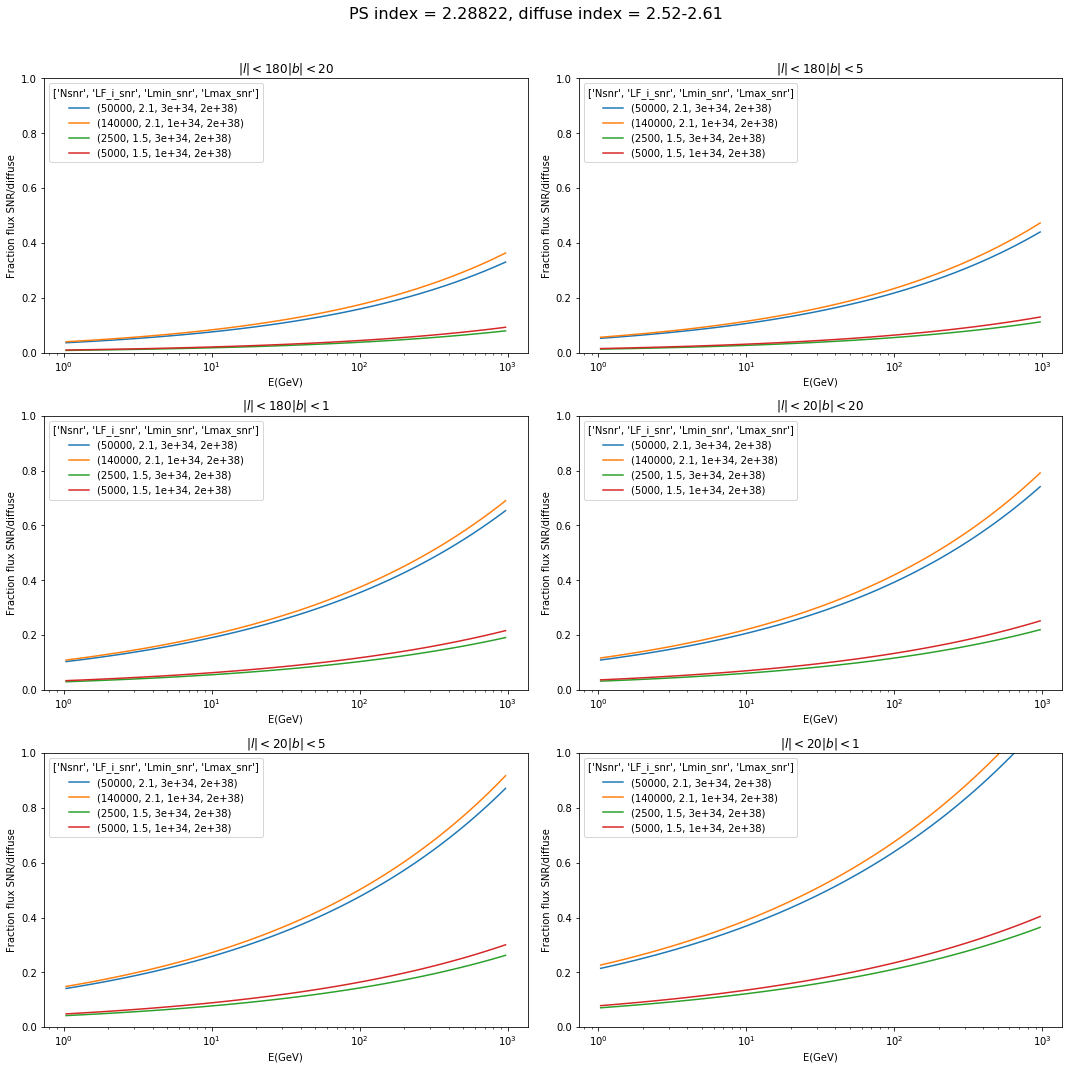

In [28]:
snr_frac = np.array(snr_frac)
fig2 = plt.figure(figsize=(15,20))
gs2 = gridspec.GridSpec(4,2)
for di in range(len(spec_diff_lb)):
    gsi2 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs2[di])
    ax2 = plt.Subplot(fig2,gs2[di]) 
    for i,sf in enumerate(snr_frac):      
        div = snr_frac[i,di]
        ax2.semilogx(E,div,label=options_print[i])
    ax2.set_ylim([0.001,1])
    ax2.set_title(r'$|l| < %s |b| < %s$'%lb[di])
    ax2.set_xlabel('E(GeV)')
    ax2.set_ylabel('Fraction flux SNR/diffuse')
    fig2.add_subplot(ax2)
    plt.legend(loc=2, title=options_labels[0:4])
##Plot legend in seperate subplot
fig2.suptitle(r'PS index = %s, diffuse index = 2.52-2.61'%(snr_index),fontsize=16)
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('fraction_ps_diffuse_1.pdf')

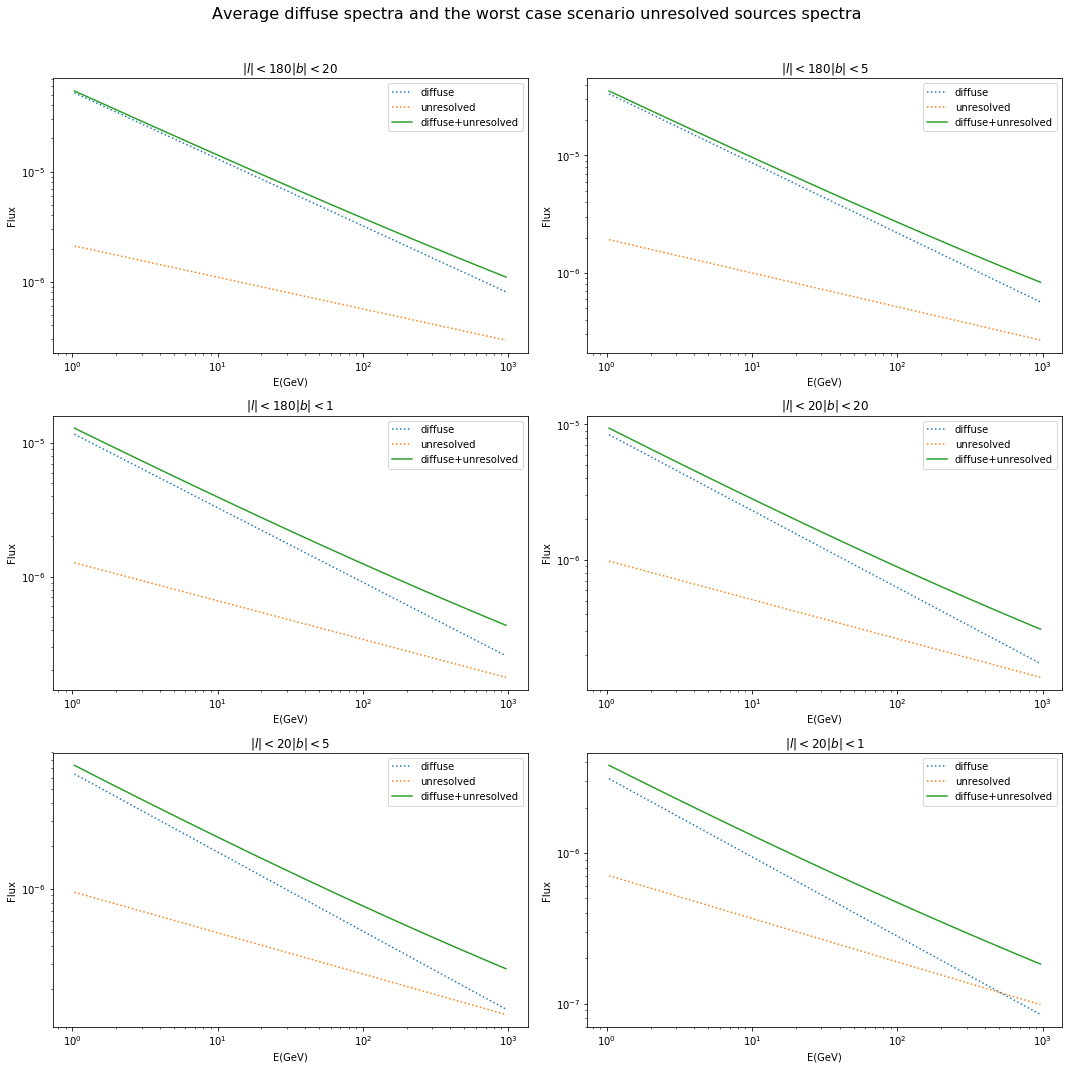

In [32]:
###Plot the fraction of unresolved/diffuse emission
snr_spec = np.array(snr_spec)
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(4,2)

for di in range(len(spec_diff_lb)):
    gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[di])
    ax = plt.Subplot(fig,gs[di]) 
    for i,sf in enumerate(snr_spec):      
        spec = snr_spec[i,di]
        #ax.loglog(E,E**2*spec,label=options_print[i])
    ax.loglog(E,E**2*(spec_diff_lb[di]),label='diffuse',linestyle=':')
    ax.loglog(E,E**2*(snr_spec[1,di]),label='unresolved',linestyle=':')
    ax.loglog(E,E**2*(spec_diff_lb[di]+snr_spec[1,di]),label='diffuse+unresolved',linestyle='-')

        
    #ax.set_ylim([0.001,1])
    ax.set_title(r'$|l| < %s |b| < %s$'%lb[di])
    ax.set_xlabel('E(GeV)')
    ax.set_ylabel('Flux')
    fig.add_subplot(ax)
    plt.legend(loc=1)#, title=options_labels[0:4])
##Plot legend in seperate subplot
fig.suptitle(r'Average diffuse spectra and the worst case scenario unresolved sources spectra',fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('spectra')